In [1]:
#!sudo pip install pytube

In [2]:
#from pytube import YouTube
def download(url):
    youtubeObject = YouTube(url)
    youtubeObject = youtubeObject.streams.get_lowest_resolution()
    try:
        youtubeObject.download()
    except:
        print("An error has occurred")
    print("Download is completed successfully")

#url = "https://www.youtube.com/watch?v=FJZ-BHBKyos" # car chase
#url = "https://www.youtube.com/watch?v=1gwglom4FeA" # 8 hr nature
#url = "https://www.youtube.com/watch?v=8W1qF7l2A1c" # 6 hr nature
#download(url)

In [3]:

!pip install scikit-video

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import cv2
import numpy as np
import skvideo.io  
import matplotlib.pyplot as plt

In [5]:
'''
##NOTE: use vreader and then create a downsampled np array
## try 36x64
resized_vid_arr = []
videodata = skvideo.io.vread("car_chase.mp4")  
for v in videodata:
  roi = cv2.resize(v, (36, 64))
  roi = roi.astype("float") / 255.0
  # roi = img_to_array(roi)
  # roi = np.expand_dims(roi, axis=0)
  resized_vid_arr.append(roi) 
resized_vid_arr = np.array(resized_vid_arr)
'''
resized_vid_arr = np.load("resized_vid_arr.npy")

In [6]:
resized_vid_arr.sum()

39977099.83529407

In [7]:
resized_vid_arr.shape

(18547, 64, 36, 3)

In [8]:
from moviepy.video.io.VideoFileClip import AudioFileClip
audioclip = AudioFileClip('car_chase.mp4')
# audioclip = videoclip.audio
audio_array = audioclip.to_soundarray()

In [9]:
video_and_audio_arr = []
aud_per_frame = audio_array.shape[0]// resized_vid_arr.shape[0]
for i in range(len(resized_vid_arr)):
  aud_in = audio_array[i*aud_per_frame : (i+1)*aud_per_frame+1]
  vec_in = [resized_vid_arr[i], aud_in]
  video_and_audio_arr.append(vec_in)

In [10]:
fps = 30
def make_frame(t):
  t = int(t * fps)
  # print(t)
  return video_and_audio_arr[t][0]

from moviepy.video.io.VideoFileClip import VideoClip
myclip = VideoClip(make_frame, duration = 20)

In [11]:
myclip.write_videofile('test.mp4', fps = 30)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [12]:
## concatonate the audio
audio = video_and_audio_arr[0][1]
for i in range(20*40):
  next_aud = video_and_audio_arr[i+1][1]
  audio = np.vstack((audio, next_aud))
print(audio.shape)

(1179072, 2)


In [13]:
!pip install pydub

Defaulting to user installation because normal site-packages is not writeable


In [14]:
import pydub 

def write(f, sr, x, normalized=True):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

# sr = (audio_array.shape[0]// resized_vid_arr.shape[0])*fps
#write('test_audio_2.mp3', sr, audio)

*training loop from cs189 hw*

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import gc

In [16]:
class VideoAudioDataset(Dataset):
    def __init__(self, video_frames, audio_frames, num_frames):
        self.video_frames = torch.tensor(video_frames, dtype=torch.float32).permute(0,3,2,1) # Permute to (N, C, H, W)
        self.aud_per_frame = audio_frames.shape[0]// (video_frames.shape[0])
        clip_amount = audio_frames.shape[0] % self.aud_per_frame
        self.audio_frames = torch.tensor(audio_frames[:-clip_amount], dtype=torch.float32).reshape(-1, self.aud_per_frame,audio_frames.shape[1]).permute(0,2,1) # Permute to (N, C, A)
        print(self.audio_frames.shape)
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_frames)

    def __getitem__(self, idx):
        idx += 1
        if idx < self.num_frames:
          num_zeros_needed = self.num_frames - idx
          vid_zeros = torch.zeros(num_zeros_needed, *self.video_frames[0].shape)
          aud_zeros = torch.zeros(num_zeros_needed, *self.audio_frames[0].shape)
          vid = torch.vstack((vid_zeros, self.video_frames[0:idx])).transpose(0,1)
          aud = torch.vstack((aud_zeros, self.audio_frames[0:idx])).transpose(0,1).reshape(2,-1).transpose(0,1)
          #print("aud_shape:", aud.shape, "reshaped:", torch.vstack((aud_zeros, self.audio_frames[0:idx])).transpose(0,1).shape)
          return (vid, aud)
        #vid shape example torch.Size([32, 3, 10, 36, 64])
        # aud shape example torch.Size([32, 2, 14710])
        vid = self.video_frames[idx-self.num_frames:idx].transpose(0,1)
        aud = self.audio_frames[idx-self.num_frames: (idx)].transpose(0,1).reshape(2,-1).transpose(0,1)
        #print("aud_shape:", aud.shape)
        # print('idx = ', idx, ' aud.size = ', aud.shape)
        return (vid, aud)

https://github.com/antecessor/Wavenet << source!

In [17]:
class AudConvEmbedding(nn.Module):
  def __init__(self, in_channels, output_dim):
    super(AudConvEmbedding, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 5, stride = 2),
        nn.LayerNorm(7353),
        nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 5, stride = 2),
        nn.LayerNorm(3675),
        nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 5, stride = 2),
        nn.LayerNorm(1836),
        nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 5, stride = 2),
        nn.LayerNorm(916),
        nn.Conv1d(in_channels = 2, out_channels = 2, kernel_size = 5, stride = 2),
        nn.LayerNorm(456),
        nn.Linear(456, output_dim)
    )
  
  def forward(self, x):
    return self.conv_layers(x)

In [18]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads, dropout):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.dropout = nn.Dropout(dropout)

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, input_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def scaled_dot_product(self, q, k, v, mask=None):
        d_k = q.size()[-1]
        attn_logits = torch.matmul(q, k.transpose(-2, -1))
        attn_logits = attn_logits / np.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
        attention = F.softmax(attn_logits, dim=-1)
        attention = self.dropout(attention)
        values = torch.matmul(attention, v)
        return values, attention

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        #print(q.shape, k.shape, v.shape)
        # Determine value outputs
        values, attention = self.scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        #print(values.shape)
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [19]:
class AddPosEncoding(nn.Module):
  def __init__(self, d_model = 256, input_dropout = 0.1, timing_dropout = 0.1, max_len = 512):
    super(AddPosEncoding, self).__init__()
    self.d_model = d_model
    self.input_dropout = input_dropout
    self.timing_dropout = timing_dropout
    self.max_len = max_len

    self.timing_table = nn.Parameter(torch.FloatTensor(max_len, d_model))
    nn.init.normal_(self.timing_table)
    self.input_dropout = nn.Dropout(input_dropout)
    self.timing_dropout = nn.Dropout(self.timing_dropout)

  
  def forward(self,x):
    x = self.input_dropout(x)
    timing = self.timing_table[None, :x.shape[1], :]
    timing = self.timing_dropout(timing)
    return x + timing 



In [20]:
class GLUTanh(nn.Module):
    def __init__(self, input_size, output_size):
        super(GLUTanh, self).__init__()
        self.glu = nn.GLU(dim=-1)
        self.linear = nn.Linear(input_size // 2, output_size)

    def forward(self, x):
        x = self.glu(x)
        x = self.linear(x)
        x = torch.tanh(x)
        return x

In [21]:
class AudTransformer(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dims = 256, seq_len = 100, dim_ff = 1024, n_layers = 6, n_head = 8, d_qkv = 64, dropout = 0.1):
        super(AudTransformer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_dims = hidden_dims
        self.dim_ff = dim_ff
        self.n_layers = n_layers
        self.n_head = n_head
        self.d_qkv = d_qkv
        self.dropout = dropout

        self.mha_list = nn.ModuleList()
        self.mha_norms = nn.ModuleList()
        self.pff_list = nn.ModuleList()
        self.pff_norms = nn.ModuleList()

        self.add_timing = AddPosEncoding(hidden_dims, max_len = seq_len)

        #self.embedding = AudConvEmbedding(2, self.hidden_dims)
        self.embedding2 = nn.Linear(2, self.hidden_dims)
        
        #self.output_norm = nn.LayerNorm(hidden_dims)
        #self.linear = nn.Linear(self.hidden_dims, 2)
        #self.output_proj = nn.Conv1d(in_channels = seq_len, out_channels = 1, kernel_size = 1, stride = 1)
        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dims),
            nn.Conv1d(in_channels = seq_len, out_channels = 1, kernel_size = 1, stride = 1),
            nn.Linear(self.hidden_dims, 1024),
            nn.GLU(),
            nn.Linear(512, 2)
        )

        
        for _ in range(n_layers):
          self.mha_list.append(MultiheadAttention(self.hidden_dims, self.d_qkv, self.n_head, self.dropout))
          self.mha_norms.append(nn.LayerNorm(hidden_dims))
          self.pff_list.append(nn.Sequential(
                              nn.Linear(hidden_dims, dim_ff),
                              nn.ReLU(),
                              nn.Linear(dim_ff, hidden_dims),
                              nn.Dropout(self.dropout)
                              ))
          self.pff_norms.append(nn.LayerNorm(hidden_dims))

  def forward(self, x):
    #print("tf:", x.shape)
    #x = self.embedding(x).transpose(2,1)
    x = self.embedding2(x)
    x = x + self.add_timing(x)
    #print("tf emb:", x.shape)
    for i in range(self.n_layers):
      x_norm = self.mha_norms[i](x)
      #print('x_norm.shape', x_norm.shape)
      att_out = self.mha_list[i](x)
      #print(att_out.shape)
      x = x_norm + att_out
      x_norm = self.pff_norms[i](x)
      ff_out = self.pff_list[i](x_norm)
      x = x_norm + ff_out
      #print("tf layer:", i, x.shape)
    
    #x = self.output_norm(x)
    #print("tf:", x.shape)
   # x = self.linear(x)
    x = self.output_proj(x)
    #print("tf:", x.shape)
    #print("tf:", x.shape)
    return x


In [22]:
class VidToAudFusion(nn.Module):
    def __init__(self, audio_dim, video_dims, audio_channels, vid_channels, dropout_prob=0.1, num_frames=10):
        super(VidToAudFusion, self).__init__()
        self.dim_proj = nn.Linear(video_dims[0] * video_dims[1] * num_frames, (audio_dim * num_frames) - 1)
        self.audio_dim = audio_dim
        self.video_dims = video_dims
        self.vid_channels = vid_channels

        if audio_channels == vid_channels:
            self.channel_projection = nn.Identity()
        else:
            self.channel_projection = nn.Sequential(
                nn.Conv2d(vid_channels, audio_channels, kernel_size=1, stride=1, bias=True),
            )
        self.channel_projection2 = nn.Sequential(
                nn.Conv1d(num_frames, 2, kernel_size=1, stride=1, bias=True),
            )
            
    def forward(self, x):
      #x = x.reshape(x.shape[0], x.shape[1], x.shape[2], -1)
      #print("vid to aud:", x.shape)
      audio_proj = torch.flatten(x, start_dim=3)
      #print("vid to aud:", x.shape)
      #audio_proj = self.dim_proj(audio_proj)
      #print("vid to aud:", audio_proj.shape)
      #print(audio_proj.shape)
      audio_proj = self.channel_projection(audio_proj).squeeze(2)
      #print("vid to aud:", audio_proj.shape)
      #audio_proj = self.channel_projection2(audio_proj)
      audio_proj = audio_proj.reshape(audio_proj.shape[0], -1)
      #print("vid to aud:", audio_proj.shape)
      audio_proj = self.dim_proj(audio_proj)
      #print("vid to aud:", audio_proj.shape)
      #print(audio_proj.shape)
      return audio_proj

In [23]:
class ConvResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1, stride=1, kernel_size=3, padding=1):
        super(ConvResBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.norm1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.norm2 = nn.BatchNorm3d(out_channels)
        self.stride = stride
        
        if in_channels == out_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm3d(out_channels)
            )
            
    def forward(self, x):
        residual = self.skip_connection(x)
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.dropout(out)
        
        out = self.relu(out)
        out = out + residual

        return out

class ConvResBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.1, stride=1, kernel_size=3, padding=1):
        super(ConvResBlock2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
        if in_channels == out_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = self.skip_connection(x)
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.dropout(out)
        
        out = self.relu(out)
        out = out + residual

        return out

In [24]:
### combines video into audio input vector and then passes through wavenet

class AttAudVideoNet(nn.Module):
    def __init__(self,audio_input_shape, video_input_shape,in_channels=2,out_channels=2): ## NEED TO DEBUG THESE hyperperams 4.29
        super().__init__()
        self.transformer=AudTransformer(in_channels, out_channels, hidden_dims = 256, seq_len = 1470, dim_ff = 1024, n_layers = 6, n_head = 8, d_qkv = 64, dropout = 0.1) 
        #self.activation = nn.Tanh()
        self.activation = GLUTanh(2,2)
        self.vid_convs = nn.ModuleList([
            ConvResBlock3D(3, 64),
            ConvResBlock3D(64, 128),
            ConvResBlock3D(128, 256)
        ])
        self.audio_input_shape = audio_input_shape
        self.video_input_shape = video_input_shape
        vid_dims_list = self.get_video_dims(video_input_shape)
        self.vid_to_aud = VidToAudFusion(self.audio_input_shape[-1], vid_dims_list[2], 1, 256, num_frames=video_input_shape[2])
        
        #self.output_lin = nn.Linear(256*in_channels, out_channels)

    def get_video_dims(self, video_input_shape):
        shape_list = []
        test_data = torch.ones(video_input_shape)
        out = self.vid_convs[0](test_data)
        shape_list.append((out.shape[-2],out.shape[-1]))
        for layer in self.vid_convs[1:]:
            out = layer(out)
            shape_list.append((out.shape[-2],out.shape[-1]))
        return shape_list

    def forward(self,vid, aud):
        #print(vid.shape, aud.shape)
        for i in range(len(self.vid_convs)):
          vid = self.vid_convs[i](vid)
        #print(vid.shape)
        vid_to_aud = self.vid_to_aud(vid)
        #print(vid_to_aud.shape, aud.shape)
        #print(vid_to_aud.shape, aud.shape)
        aud = aud + vid_to_aud.unsqueeze(2)
        aud=self.transformer(aud)
        #print(aud.shape)
        #aud=aud.reshape(aud.shape[0], -1)
        #aud = self.output_lin(aud)
        #print('output shape = ', aud.shape)
        return self.activation(aud)



In [25]:
print(resized_vid_arr.shape, resized_vid_arr.size)
print(audio_array.size)

(18547, 64, 36, 3) 128196864
54583452


In [26]:
train_data = VideoAudioDataset(resized_vid_arr[:int(len(resized_vid_arr)*0.8)], audio_array[:int(len(audio_array)*0.8)], num_frames = 1)
valid_data = VideoAudioDataset(resized_vid_arr[int(len(resized_vid_arr)*0.8):], audio_array[int(len(audio_array)*0.8):], num_frames = 1)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

torch.Size([14842, 2, 1471])
torch.Size([3710, 2, 1471])


In [27]:
for x in train_loader:
  print(x[0].shape)
  print(x[1].shape)
  break
  
count = 0
# for x in valid_loader:
#   count += 1
#   if count == 10:
#     print(x[0].shape)
#     print(x[1].shape)
#     break

torch.Size([32, 3, 1, 36, 64])
torch.Size([32, 1471, 2])


In [28]:
from tqdm.notebook import tqdm, trange

# wavenet = WaveNet(in_channels=2,out_channels=2,kernel_size=2,stack_size=23,layer_size=6).cuda().train()
audio_test_data = torch.ones((1,2,1471))
vid_test_data = torch.ones((1,3,1,36,64))

wavenet = AttAudVideoNet(audio_input_shape=audio_test_data.shape, video_input_shape=vid_test_data.shape,in_channels=2,out_channels=2).cuda().train()
#load_path = 'transformer_vid_model2_5.7.pt'
#wavenet.load_state_dict(torch.load(load_path))

epochs= 20
globalStep=500
lr = 8e-6

optimizer=torch.optim.AdamW(wavenet.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
  optimizer,
  lr,
  epochs=epochs,
  steps_per_epoch=len(train_loader),
  pct_start=0.03,  # Warm up for 3% of the total training time
  )
lossFunction = torch.nn.CrossEntropyLoss()

def calc_accuracy(Out,Y):
    max_vals, max_indices = torch.max(Out,1)
    train_acc = (max_indices == Y).sum().item()/max_indices.size()[0]
    return train_acc
  


for epoch in range(epochs):
    for step, (vid_frames,aud_frames) in tqdm(enumerate(train_loader),desc="Training"):
         #vid_frames = vid_frames.cuda()
         target = aud_frames[:,-1,].cuda()
         aud_frames = aud_frames[:,:-1,:].cuda()
         vid_frames = vid_frames.cuda()
         #print(target.shape)
         #print(aud_frames.shape)
         output = wavenet(vid_frames, aud_frames).squeeze()
         #print(output.shape)
         #print('ttt', output.shape, target.shape)
         #print(output[0].detach().cpu().numpy(), target[0].cpu().numpy())
         #print(output.shape)
         #print(output)
         #print(output.dtype, target.dtype)

         loss = lossFunction(output,target)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         scheduler.step()
         if step%globalStep==0:
            # scheduler.step()
            # print(output.detach().numpy())
            # print(y_train.numpy())
            with torch.no_grad():
                accuracy=0
                val_loss=0
                for stepTest, (vid_frames,aud_frames) in tqdm(enumerate(valid_loader),desc="Validation"):
                    vid_frames = vid_frames.cuda()
                    target = aud_frames[:,-1,].cuda()
                    aud_frames = aud_frames[:,:-1,:].cuda()
                    output = wavenet(vid_frames, aud_frames).squeeze()
                    if stepTest==0:
                        print(target[:3])
                        print(output[:3])
                        print(lossFunction(output[0],target[0]).item())
                    #accuracy+=calc_accuracy(output,target)*100
                    val_loss+= lossFunction(output,target).item()
                    if stepTest>200:
                        print(output)
                        break
            print(f"loss for step {step} : {val_loss/stepTest}")

         
    print(f"epoch {epoch}")

    save_path = 'transformer_vid_model2_5.8.pt'
    torch.save(wavenet.state_dict(), save_path)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0105,  0.0171],
        [-0.1166,  0.3245],
        [-0.2510, -0.0600]], device='cuda:0')
tensor([[ 0.2175, -0.2193],
        [ 0.2163, -0.2176],
        [ 0.2174, -0.2191]], device='cuda:0')
0.021243445575237274
loss for step 0 : 0.005178775217222131
epoch 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0713,  0.1741],
        [-0.3958, -0.5508],
        [-0.0671, -0.5965]], device='cuda:0')
tensor([[ 0.1520, -0.1306],
        [ 0.2071, -0.2052],
        [ 0.1828, -0.1724]], device='cuda:0')
0.18701845407485962
loss for step 0 : -0.01034222493029159
epoch 1


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.1577,  0.0436],
        [-0.2621, -0.0840],
        [ 0.2265,  0.0330]], device='cuda:0')
tensor([[ 0.9991, -0.9999],
        [ 0.9994, -0.9999],
        [ 0.9990, -0.9999]], device='cuda:0')
0.11269187182188034
loss for step 0 : -0.12750097112730147
epoch 2


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.2652, -0.0080],
        [ 0.0266, -0.0584],
        [ 0.2816,  0.0038]], device='cuda:0')
tensor([[-0.9992,  0.9999],
        [ 0.9989, -0.9999],
        [ 0.8835, -0.9436]], device='cuda:0')
0.5629091858863831
loss for step 0 : -0.1727741721207681
epoch 3


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0350,  0.4900],
        [ 0.3387, -0.1860],
        [ 0.1795,  0.3341]], device='cuda:0')
tensor([[-0.6810,  0.8203],
        [ 1.0000, -1.0000],
        [-0.9324,  0.9788]], device='cuda:0')
0.1581157147884369
loss for step 0 : -0.1827502172521275
epoch 4


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0448,  0.1189],
        [-0.2984, -0.0215],
        [ 0.1052,  0.3193]], device='cuda:0')
tensor([[ 0.3345, -0.3699],
        [ 0.9939, -0.9988],
        [-0.6849,  0.8203]], device='cuda:0')
0.14949822425842285
loss for step 0 : -0.18361273268642633
epoch 5


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.0381,  0.0584],
        [ 0.0780, -0.3155],
        [ 0.3007,  0.2119]], device='cuda:0')
tensor([[-0.9999,  1.0000],
        [ 1.0000, -1.0000],
        [-0.9996,  1.0000]], device='cuda:0')
-0.07365452498197556
loss for step 0 : -0.153445117616945
epoch 6


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.1075,  0.0814],
        [-0.1651, -0.5117],
        [ 0.0926,  0.0261]], device='cuda:0')
tensor([[-0.4020,  0.5465],
        [ 1.0000, -1.0000],
        [-0.9957,  0.9994]], device='cuda:0')
-0.11045889556407928
loss for step 0 : -0.1763072678576345
epoch 7


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.1359,  0.1008],
        [ 0.3656,  0.1052],
        [-0.0994, -0.1203]], device='cuda:0')
tensor([[ 0.9988, -0.9998],
        [ 0.7511, -0.8321],
        [ 0.8522, -0.9165]], device='cuda:0')
0.23161110281944275
loss for step 0 : -0.19415836807178413
epoch 8


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.2661, -0.0549],
        [-0.2734, -0.5945],
        [ 0.0748,  0.1518]], device='cuda:0')
tensor([[-0.9957,  0.9993],
        [ 1.0000, -1.0000],
        [ 0.1400, -0.1198]], device='cuda:0')
-0.5718309879302979
loss for step 0 : -0.19186586888264054
epoch 9


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[0.3238, 0.3746],
        [0.6063, 0.5200],
        [0.5210, 0.3739]], device='cuda:0')
tensor([[-0.3615,  0.4965],
        [-0.0672,  0.1449],
        [-0.0862,  0.1688]], device='cuda:0')
0.5246517658233643
loss for step 0 : -0.1887790775169497
epoch 10


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.3123,  0.3301],
        [-0.1867, -0.4382],
        [-0.1004,  0.2679]], device='cuda:0')
tensor([[ 0.0384,  0.0100],
        [ 1.0000, -1.0000],
        [-1.0000,  1.0000]], device='cuda:0')
0.4455713629722595
loss for step 0 : -0.20046656590825676
epoch 11


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0868, -0.3904],
        [-0.1197, -0.3766],
        [-0.2073, -0.3452]], device='cuda:0')
tensor([[ 1.0000, -1.0000],
        [ 1.0000, -1.0000],
        [ 1.0000, -1.0000]], device='cuda:0')
-0.8192915916442871
loss for step 0 : -0.19923010499257107
epoch 12


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.0228,  0.1185],
        [-0.1174,  0.0904],
        [ 0.0892,  0.0751]], device='cuda:0')
tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000],
        [ 0.7496, -0.8265]], device='cuda:0')
0.06352759897708893
loss for step 0 : -0.2000417596620062
epoch 13


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[ 0.2463, -0.3540],
        [-0.2437, -0.2295],
        [ 0.0640,  0.0007]], device='cuda:0')
tensor([[ 1.0000, -1.0000],
        [-0.9999,  1.0000],
        [ 0.9992, -0.9999]], device='cuda:0')
-0.7216066718101501
loss for step 0 : -0.19792571997512942
epoch 14


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[0.4000, 0.2380],
        [0.0309, 0.1753],
        [0.2225, 0.4066]], device='cuda:0')
tensor([[ 0.9995, -0.9999],
        [-0.4784,  0.6134],
        [-0.9874,  0.9970]], device='cuda:0')
0.5569646954536438
loss for step 0 : -0.1908670428816391
epoch 15


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.1271,  0.0680],
        [-0.0470,  0.1404],
        [-0.0006, -0.1541]], device='cuda:0')
tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000],
        [ 1.0000, -1.0000]], device='cuda:0')
-0.26165249943733215
loss for step 0 : -0.199797855997863
epoch 16


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.0180,  0.0462],
        [ 0.3146,  0.0071],
        [-0.0683, -0.1294]], device='cuda:0')
tensor([[ 1.0000, -1.0000],
        [ 1.0000, -1.0000],
        [ 1.0000, -1.0000]], device='cuda:0')
0.09592027962207794
loss for step 0 : -0.20073888113965158
epoch 17


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.0535, -0.0872],
        [-0.2729, -0.2019],
        [-0.2045,  0.0519]], device='cuda:0')
tensor([[-0.9947,  0.9989],
        [-1.0000,  1.0000],
        [-1.0000,  1.0000]], device='cuda:0')
-0.12468936294317245
loss for step 0 : -0.20329253307503203
epoch 18


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor([[-0.4179, -0.1694],
        [ 0.0422,  0.0868],
        [-0.0166, -0.0809]], device='cuda:0')
tensor([[-1.0000,  1.0000],
        [-0.7278,  0.8377],
        [ 1.0000, -1.0000]], device='cuda:0')
-0.9102905988693237
loss for step 0 : -0.20240913933224003
epoch 19


In [29]:
#save_path = 'transformer_vid_model2_5.7.pt'
#torch.save(wavenet.state_dict(), save_path)
load_path = 'transformer_vid_model2_5.8.pt'
wavenet.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [30]:
class VideoOnlyDataset(Dataset):
    def __init__(self, video_frames, num_frames):
        self.video_frames = torch.tensor(video_frames, dtype=torch.float32).permute(0,3,2,1) # Permute to (N, C, H, W)
        self.num_frames = num_frames

    def __len__(self):
        return len(self.video_frames)

    def __getitem__(self, idx):
        idx += 1
        if idx < self.num_frames:
          num_zeros_needed = self.num_frames - idx
          vid_zeros = torch.zeros(num_zeros_needed, *self.video_frames[0].shape)
          vid = torch.vstack((vid_zeros, self.video_frames[0:idx])).transpose(0,1)
          return vid
        #vid shape example torch.Size([32, 3, 10, 36, 64])
        # aud shape example torch.Size([32, 2, 14710])
        vid = self.video_frames[idx-self.num_frames:idx].transpose(0,1)
        # print('idx = ', idx, ' aud.size = ', aud.shape)
        return vid

In [127]:
### generate audio for video from model
num_frames = 1

#start_index = int(len(resized_vid_arr)*0.8) + num_frames
start_index = int(len(resized_vid_arr)*0.6) + num_frames
audio_list = []
vid_test_shape = (1,3,10,36,64)
zero_frame = torch.zeros((vid_test_shape[3], vid_test_shape[4]))

aud_per_vid_frame = 1471
#audio_start_index = int(len(audio_array)*0.8)
audio_start_index = int(len(audio_array)*0.6)
print(audio_start_index)
aud_input_arr = torch.tensor(audio_array[audio_start_index:audio_start_index+(num_frames * aud_per_vid_frame) - 1], dtype=torch.float32).cuda().unsqueeze(0)
print(aud_input_arr.shape)

#aud_input_arr = torch.zeros((1,2,(num_frames * aud_per_vid_frame) - 1)).cuda()
print(aud_input_arr.shape)

input_vid = resized_vid_arr[start_index:]
gen_data = VideoOnlyDataset(input_vid, num_frames = num_frames)
gen_loader = DataLoader(gen_data, batch_size=1, shuffle=False)


#NOTE: GEN NEEDS TO BE FIXED TO ACCOUNT FOR MULTIPLE AUDIO RUNS PER FRAME
wavenet.eval()
for i,vid in enumerate(gen_loader):
    vid = vid.cuda()
    print(vid.shape)
    for j in trange(aud_per_vid_frame):
        with torch.no_grad():
            #print(aud_input_arr.shape)
            audio_output = wavenet(vid.cuda(), aud_input_arr.cuda()).cpu()
            #print(audio_output, audio_output.shape)
            audio_list.append(audio_output.squeeze().cpu().numpy())
            #print(aud_input_arr)
            aud_input_arr = aud_input_arr[:, 1:, :]
            #print(aud_input_arr.shape, audio_output.shape)
            #print(aud_input_arr)
            
            aud_input_arr = torch.cat((aud_input_arr, audio_output.cuda()), 1)
            #print(aud_input_arr)
    if i > 100:
        break
np.array(audio_list).shape

16375035
torch.Size([1, 1470, 2])
torch.Size([1, 1470, 2])
torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

torch.Size([1, 3, 1, 36, 64])


  0%|          | 0/1471 [00:00<?, ?it/s]

(150042, 2)

In [141]:
gen_loader = DataLoader(gen_data, batch_size=1, shuffle=False)
vid_list = []
for i,vid in enumerate(gen_loader):
    #print(vid.shape)
    vid_np = vid.numpy().squeeze(0).transpose(1,3,2,0)
    #print(vid_np.shape)
    for frame in vid_np:
        frame = cv2.resize(frame, (640, 360))
        vid_list.append(frame)
    if i > 100:
        break

In [143]:
video_np = np.array(vid_list)
print(np.array(vid_list).shape)

(102, 360, 640, 3)


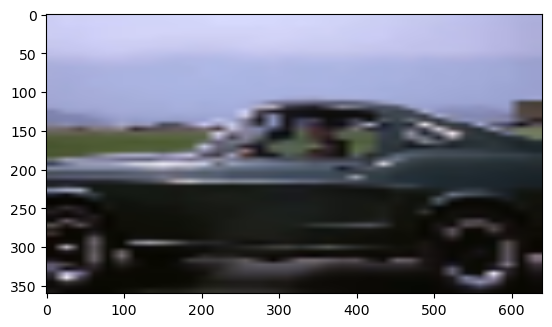

In [144]:
plt.imshow(video_np[19])

In [145]:
print(len(vid_list))

102


In [146]:
fps = 15
def make_frame(t):
  t = int(t * fps)
  # print(t)
  return video_np[t]

from moviepy.video.io.VideoFileClip import VideoClip
myclip = VideoClip(make_frame, duration = 3)
myclip.write_videofile('vid_frames2.mp4', fps = fps)

Moviepy - Building video vid_frames2.mp4.
Moviepy - Writing video vid_frames2.mp4



Moviepy - Done !
Moviepy - video ready vid_frames2.mp4


In [147]:
path = 'test_transformer_model2_out_5.8_2_video.raw'
np.save(path, video_np)

In [148]:
print(len(audio_list))

150042


In [149]:
print(np.array(audio_list).shape)
audio_np = np.array(audio_list).transpose(1,0)
audio_np.shape

(150042, 2)


(2, 150042)

In [150]:
'''
audio_cpu = audio_output.cpu()
audio_np = audio_cpu.detach().numpy()
audio_np.shape
'''

'\naudio_cpu = audio_output.cpu()\naudio_np = audio_cpu.detach().numpy()\naudio_np.shape\n'

In [151]:
fps = 30
sr = (audio_array.shape[0]// resized_vid_arr.shape[0])*fps
write('test_transformer_model2_out_5.8_2.mp3', sr, audio_np)

In [152]:
print(sr)

44130


In [153]:
path = 'test_transformer_model2_out_5.8_2.raw'
np.save(path, audio_np)

In [154]:
from moviepy.editor import *
  
clip = VideoFileClip("vid_frames.mp4")
  
clip = clip.subclip(0, 3)
  
# loading audio file
audioclip = AudioFileClip("test_transformer_model2_out_5.8_1.mp3")
  
# adding audio to the video clip
videoclip = clip.set_audio(audioclip)

videoclip.write_videofile('car.mp4', fps = 30)
  
# showing video clip
videoclip.ipython_display()

Moviepy - Building video car.mp4.
MoviePy - Writing audio in carTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video car.mp4



Moviepy - Done !
Moviepy - video ready car.mp4
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
